In [1]:
import pickle as pkl
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras.layers import *
import keras.backend as K

In [2]:
savepath = './results/'
trainin = pkl.load(open(savepath + "trainin", "rb"))
trainout = pkl.load(open(savepath + "trainout", "rb"))
testin = pkl.load(open(savepath + "testin", "rb"))
testout = pkl.load(open(savepath + "testout", "rb"))

In [3]:
print(trainin.shape)
print(trainout.shape)

(75000, 2401)
(75000, 1)


In [4]:
def mae(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return K.mean(loss)

In [5]:
def mse(y_true, y_pred):
    y_pred = tf.cast(y_pred, tf.float32)
    loss = tf.keras.losses.MSE(y_true, y_pred)
    return K.mean(loss)

In [6]:
def RemoveOutliers(inputs):
    quants = tfp.stats.quantiles(inputs, num_quantiles=4)
    iqr = quants[3] - quants[1]
    upper = quants[3] + K.constant(1.5) * iqr
    lower = quants[1] - K.constant(1.5) * iqr
    zeros = K.zeros_like(inputs)
    outputs = K.switch(K.greater(inputs, upper), zeros, inputs)
    outputs = K.switch(K.less(inputs, lower), zeros, outputs)
    
    return outputs

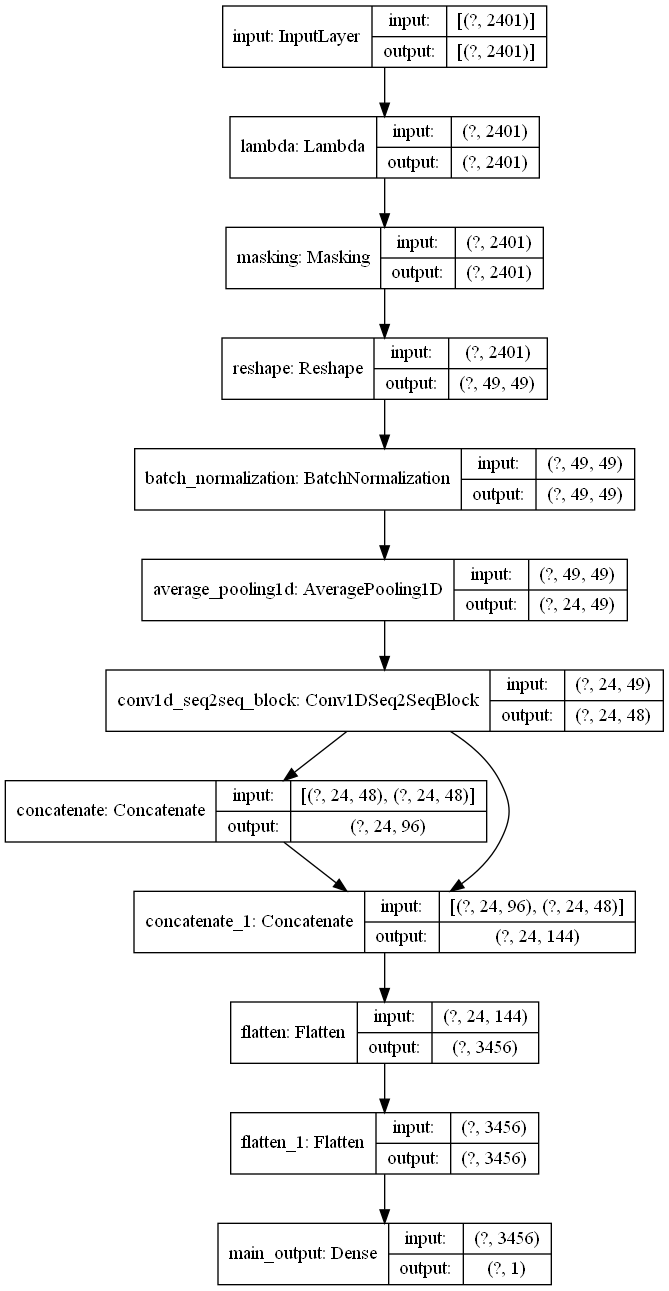

In [7]:
#Input and output sizes
input_size = tf.transpose(trainin).shape[0]
output_size = tf.transpose(trainout).shape[0]

#ML Hyperparameters
lr = 10e-4 #learning rate
epochs = 15 #number of passes of the data
batchsize = 32 #number of images fed in at a time
version = 5 #model version number if same hyperparameters
iterations = trainin.shape[0]//batchsize #number of batches used per epoch
optimizer = tf.keras.optimizers.Adam(lr, beta_1=.9, beta_2=.999, epsilon=1e-2, decay=0.) #ML optimizer
loss_fn = mae #loss function

metric =  keras.metrics.MeanSquaredError() #metric to be used for training
val_metric = keras.metrics.MeanSquaredError() #metric to be used for validation

#Configuration dictionary for ML model
config = {'act1': 'relu', 'act2': 'linear', 'size1': 256, 'size2': 64, 'size3': 32}

'''
#ML model in keras functional API (CNN with max pooling fed into dense with batch normalization) 
inputs = keras.Input(shape=(input_size,), name='input')
x = Lambda(RemoveOutliers)(inputs)
x = Masking(mask_value=0.0)(x)
x = Dense(int(config['size1']), input_shape=(input_size,), activation=config['act1'])(x)
x = Reshape(target_shape=(8, 8, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(128, (5,5), activation=config['act1'], padding="same")(x)
x = AveragePooling2D((2,2), strides=2)(x)
x = BatchNormalization()(x)
x = Conv2D(64, (5,5), activation=config['act1'], padding="same")(x)
x = AveragePooling2D((2,2), strides=2)(x)
x = BatchNormalization()(x)
x = Conv2D(32, (5,5), activation=config['act1'], padding="same")(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(int(config['size2']), activation=config['act1'])(x)
x = BatchNormalization()(x)
x = Dense(int(config['size3']), activation=config['act1'])(x)
x = BatchNormalization()(x)
main_output = Dense(output_size, activation=config['act2'], name='main_output')(x)

outputs = [main_output]

model = keras.Model(inputs = inputs, outputs = outputs)
modelname = ("BnCNN_%.1e_%d_%d_%d" % (lr, epochs, batchsize, version))
'''

'''
inputs = keras.Input(shape=(input_size,), name='input')
x = Lambda(RemoveOutliers)(inputs)
x = Masking(mask_value=0.0)(x)
x = Dense(256, input_shape=(input_size,), activation=config['act2'])(x)
x = Reshape(target_shape=(4, 4, 4, 4))(x)
x = BatchNormalization()(x)
x, timesteps, filters = ConvLSTM2D(64, (4,4), activation=config['act1'], padding="same", return_sequences=True, return_state=True)(x)
x = BatchNormalization()(x)
timesteps = BatchNormalization()(timesteps)
filters = BatchNormalization()(filters)
y = ConvLSTM2D(64, (4,4), activation=config['act1'], return_sequences=True)(x, initial_state=[timesteps, filters])
y = BatchNormalization()(y)
context = Attention()([x,y])
decoder_combined_context = concatenate([context, y])
y = Flatten()(decoder_combined_context)
main_output = Dense(output_size, activation=config['act2'], name='main_output')(y)

outputs = [main_output]

model = keras.Model(inputs=inputs, outputs = outputs)
modelname = ("ConvLSTM2D_Seq2Seq_%.1e_%d_%d_%d" % (lr, epochs, batchsize, version))
'''

class Conv1DSeq2SeqBlock(Layer):
    def __init__(self, input_dim):
        super(Conv1DSeq2SeqBlock, self).__init__()
        self.Conv1 = Conv1D(filters=1, 
                            kernel_size=(int(input_dim / 8)), 
                            activation=config['act1'],
                            padding='same')
        self.Conv2 = Conv1D(filters=1, 
                            kernel_size=(int(input_dim / 6)), 
                            activation=config['act1'], 
                            padding='same')
        self.Conv3 = Conv1D(filters=1, 
                            kernel_size=(int(input_dim / 4)), 
                            activation=config['act1'], 
                            padding='same')
        self.Conv4 = Conv1D(filters=1, 
                            kernel_size=(int(input_dim / 3)), 
                            activation=config['act1'], 
                            padding='same')
        self.BLSTM = Bidirectional(LSTM(1, activation=config['act1'], return_sequences=True, return_state=True))
        self.rBLSTM = Bidirectional(LSTM(1, activation=config['act1'], return_sequences=True))
        self.BatchNorm = BatchNormalization()
        self.BatchNorm2 = BatchNormalization()
        self.BatchNorm3 = BatchNormalization()

    def call(self, inputs, training):
        conv1 = self.Conv1(inputs)
        conv2 = self.Conv2(inputs)
        conv3 = self.Conv3(inputs)
        conv4 = self.Conv4(inputs)
        concat1 = concatenate([conv1, conv2, conv3, conv4], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat1)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc1 = concatenate([context, y])
        
        concat2 = concatenate([conv1, conv2, conv4, conv3], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat2)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc2 = concatenate([context, y])
        
        concat3 = concatenate([conv1, conv3, conv2, conv4], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat3)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc3 = concatenate([context, y])
        
        concat4 = concatenate([conv1, conv3, conv4, conv2], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat4)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc4 = concatenate([context, y])
        
        concat5 = concatenate([conv1, conv4, conv3, conv2], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat5)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc5 = concatenate([context, y])
        
        concat6 = concatenate([conv1, conv4, conv2, conv3], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat6)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc6 = concatenate([context, y])
        
        concat7 = concatenate([conv2, conv1, conv3, conv4], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat7)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc7 = concatenate([context, y])
        
        concat8 = concatenate([conv2, conv3, conv1, conv4], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat8)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc8 = concatenate([context, y])
        
        concat9 = concatenate([conv3, conv1, conv2, conv4], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat9)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc9 = concatenate([context, y])
        
        concat10 = concatenate([conv3, conv2, conv1, conv4], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat10)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc10 = concatenate([context, y])
        
        concat11 = concatenate([conv4, conv1, conv2, conv3], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat11)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc11 = concatenate([context, y])
        
        concat12 = concatenate([conv4, conv2, conv1, conv3], axis=-1)
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat12)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc12 = concatenate([context, y])
        
        x, f_h, f_c, b_h, b_c = self.BLSTM(concat1)
        f_h = self.BatchNorm(f_h)
        f_c = self.BatchNorm(f_c)
        b_h = self.BatchNorm(b_h)
        b_c = self.BatchNorm(b_c)
        x = self.BatchNorm2(x)
        y = self.rBLSTM(x, initial_state=[f_h, f_c, b_h, b_c])
        attn = dot([y, x], axes=[2, 2])
        attn = Activation('softmax')(attn)
        context = dot([attn, x], axes=[2,1])
        context = self.BatchNorm3(context)
        dcc1 = concatenate([context, y])
        
        

        return concatenate([dcc1, dcc2, dcc3, dcc4, dcc5, dcc6, dcc7, dcc8, dcc9, dcc10, dcc11, dcc12])


inputs = keras.Input(shape=(input_size,), name='input')
x = Lambda(RemoveOutliers)(inputs)
x = Masking(mask_value=0.0)(x)
x = Reshape(target_shape=(49, 49))(x)
x = BatchNormalization()(x)
x = AveragePooling1D()(x)
convseq2seq = Conv1DSeq2SeqBlock(x.shape[1])
combine = convseq2seq(x)
for i in range(2):
    combine = Concatenate(axis=-1)([combine, convseq2seq(x)])
combine = Flatten()(combine)
y = Flatten()(combine)
main_output = Dense(output_size, activation=config['act2'], name='main_output')(y)

outputs = [main_output]

model = keras.Model(inputs=inputs, outputs = outputs)
modelname = ("ConvSeq2SeqV2_%.1e_%d_%d_%d" % (lr, epochs, batchsize, version))
#PNG image of model structure
keras.utils.plot_model(model, 'ConvSeq2SeqV2.png', show_shapes=True)

In [8]:
#index list to be used for shuffling
# indices = tf.range(start = 0, limit = tf.shape(trainin)[0], dtype=tf.int32)

In [9]:
# #Function that trains the model on a batch of declared size
# def train_model_on_batch():
#     #Use index list shuffling to create shuffled batches for training
#     start = iteration * batchsize
#     x_batch = shuffledin[start:start + batchsize, :]
#     y_batch = shuffledout[start:start + batchsize, :]
    
#     #Gradient tape watches changes to loss as model is called
#     with tf.GradientTape() as tape:
#         current_loss = loss_fn(y_batch, model(x_batch))
    
#     #Apply gradients to optimizer based on shape of model
#     gradients = tape.gradient(current_loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     #Update the training metric
#     metric.update_state(y_batch, model(x_batch))
    
    
#     #Only calculate validation metric and validation loss once
#     if iteration == (iterations - 1):
#         val_metric.update_state(testout, model(testin))
#         val_loss = loss_fn(testout, model(testin))
#         return current_loss, metric.result(), val_loss, val_metric.result()
#     else:
#         return current_loss, 0, 0, 0

In [10]:
# #Training history lists
# loss_history = []
# metric_history = []
# val_loss_history = []
# val_metric_history = []

# #Initial loss value below which the model will start saving
# min_loss = 1

# #Customizable model training loop
# for epoch in range(epochs):
#     shuffled_indices = tf.random.shuffle(indices)
#     shuffledin = tf.gather(trainin, shuffled_indices)
#     shuffledout = tf.gather(trainout, shuffled_indices)
#     for iteration in range(iterations):
#         print("Iteration: %d / %d" % (iteration, iterations))
#         current_loss, metric_result, val_loss, val_metric_result = train_model_on_batch()
#     #For runs with many epochs, control how often loss histories are recorded and printed
#     if epoch % 1 == 0:
#         loss_history.append(current_loss.numpy())
#         metric_history.append(metric_result.numpy())
#         val_loss_history.append(val_loss.numpy())
#         val_metric_history.append(val_metric_result.numpy())
#         print("\nEpoch: {}/{} - Loss: {} - MSE: {} \n\nVal_Loss: {} - Val_MSE: {}".format(
#             (epoch + 1), epochs, loss_history[-1], metric_history[-1], val_loss_history[-1], val_metric_history[-1]))
#     #Save the model as h5 filetype which is smaller than full model data
#     if val_metric_result < .3:
#         if val_metric_result < min_loss:
#             model.save("./results/%s.h5" % modelname)
#             min_loss = val_metric_result
#     #Reset states of metrics
#     metric.reset_states()
#     val_metric.reset_states()

In [11]:
model.compile(optimizer=optimizer, 
              loss='mse', 
              metrics='mae')

In [ ]:
model.fit(trainin, 
          trainout, 
          batch_size=None, 
          epochs=epochs, 
          verbose=1, 
          validation_data=(testin, testout))

Epoch 1/15
1713/2344 [====================>.........] - ETA: 3:08 - loss: 0.0608 - mae: 0.1782

In [ ]:
model.save("./results/%s.h5" % (modelname))

In [ ]:
#PNG image of model structure
keras.utils.plot_model(model, 'ConvSeq2SeqV2.png', show_shapes=True)